#Import Library

In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models
from matplotlib import pyplot as plt


In [2]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 3
EPOCHES= 50

In [3]:
import tensorflow as tf

# Print TensorFlow version
print("TensorFlow version:", tf.__version__)

TensorFlow version: 2.17.0


In [4]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "dataset",
    shuffle=True,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE
    
)

Found 2152 files belonging to 3 classes.


In [5]:
class_names = dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

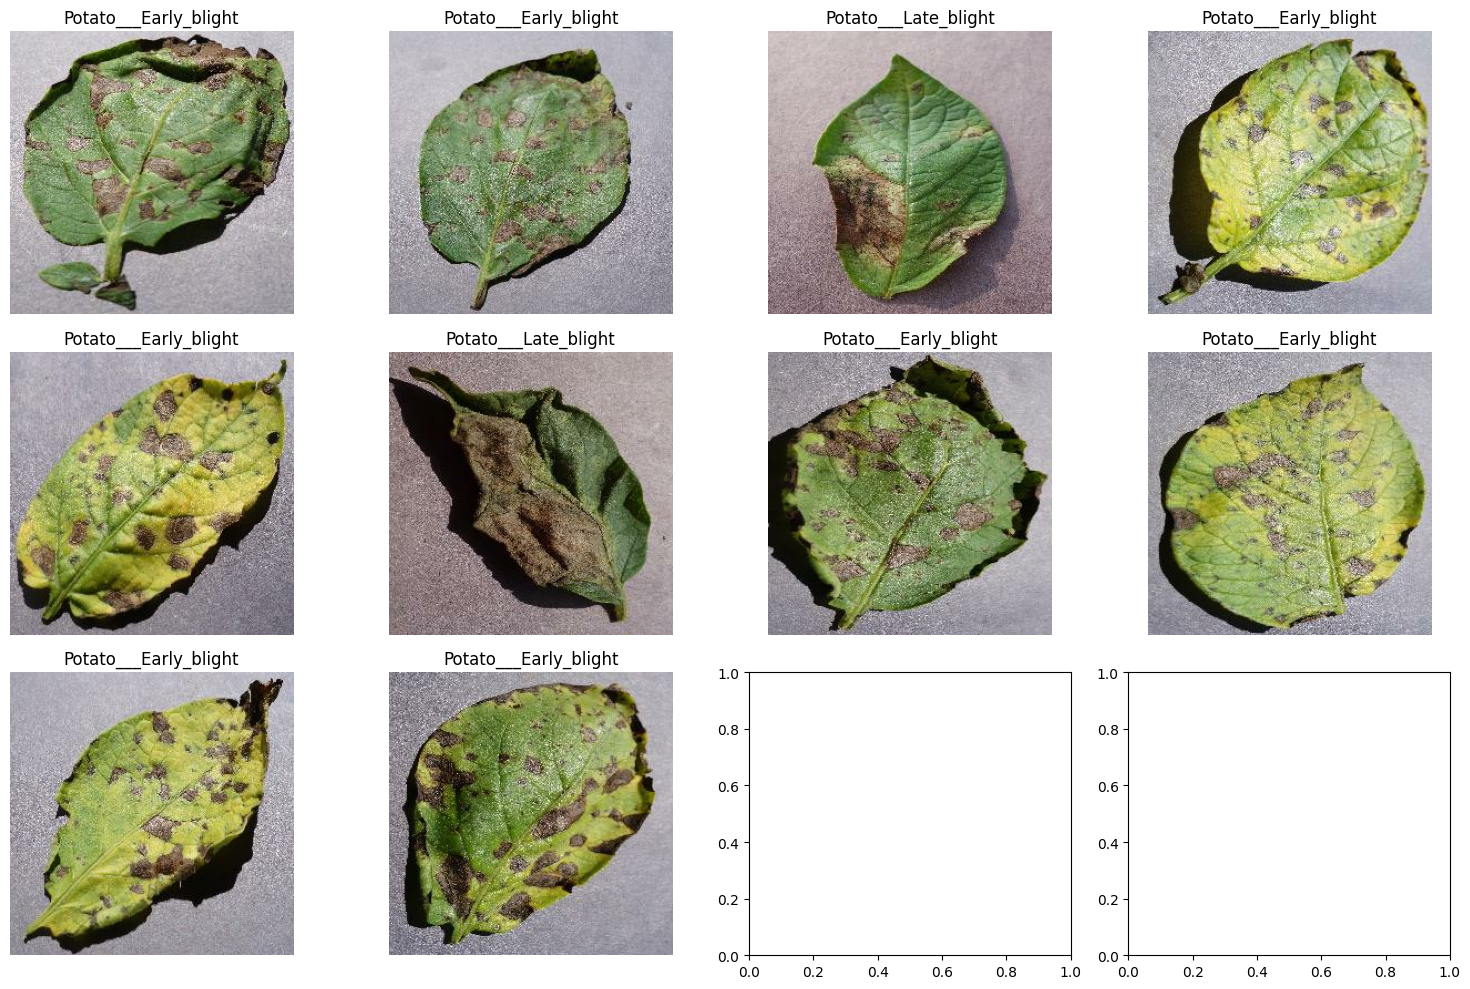

In [6]:
for image_batch, labels_batch in dataset.take(1):
    # print(image_batch.shape)
    # print(labels_batch.numpy())
    fig, axes = plt.subplots(3, 4, figsize=(15, 10))
    axes = axes.flatten()
    for i in range(10):
        axes[i].imshow(image_batch[i].numpy().astype("uint8"))
        axes[i].set_title(class_names[labels_batch[i]])
        axes[i].axis("off")

    plt.tight_layout()
    plt.show()

Test and Train Split

In [7]:
len(dataset)
# 68*32 = 2176

68

In [8]:
def preprocess_image(image):
    image = tf.image.resize(image, [IMAGE_SIZE, IMAGE_SIZE])
    image = image / 255.0  # Rescale pixel values
    return image
preprocess_image(image_batch)

<tf.Tensor: shape=(32, 256, 256, 3), dtype=float32, numpy=
array([[[[0.7921569 , 0.78431374, 0.8039216 ],
         [0.79607844, 0.7882353 , 0.80784315],
         [0.8       , 0.7921569 , 0.8117647 ],
         ...,
         [0.76862746, 0.75686276, 0.78431374],
         [0.7490196 , 0.7372549 , 0.7647059 ],
         [0.7529412 , 0.7411765 , 0.76862746]],

        [[0.78431374, 0.7764706 , 0.79607844],
         [0.7882353 , 0.78039217, 0.8       ],
         [0.7921569 , 0.78431374, 0.8039216 ],
         ...,
         [0.7411765 , 0.7294118 , 0.75686276],
         [0.75686276, 0.74509805, 0.77254903],
         [0.7882353 , 0.7764706 , 0.8039216 ]],

        [[0.7882353 , 0.78039217, 0.8       ],
         [0.7882353 , 0.78039217, 0.8       ],
         [0.7921569 , 0.78431374, 0.8039216 ],
         ...,
         [0.7529412 , 0.7411765 , 0.76862746],
         [0.7490196 , 0.7372549 , 0.7647059 ],
         [0.7647059 , 0.7529412 , 0.78039217]],

        ...,

        [[0.654902  , 0.63529414,

# 80% ==> Training dataset
# 20% ==> 10% Validation & 10% Test 

<h4> train_ds = 0.8 * len(dataset) == 54 </h4>
<h4> test_ds = 0.1 * len(dataset) = 14 </h4>


In [9]:
train_ds = dataset.take(54)
test_ds = dataset.skip(54)

In [10]:
val_ds = test_ds.take(6)
test_ds = test_ds.skip(6)


In [11]:
def dataset_partation_tf(ds,train_split=0.8,test_split=0.1,val_split=0.1,shuffle=True,shuffle_size=10000):
    if shuffle:
        ds = ds.shuffle(shuffle_size,seed=12)
    
    train_ds = ds.take(int(len(ds)*train_split))
    test_ds = ds.skip(int(len(ds)*train_split))
    
    val_ds = test_ds.take(int(len(ds)*val_split))
    test_ds = test_ds.skip(int(len(ds)*val_split))
    
    return train_ds,test_ds,val_ds

In [12]:
train_ds,test_ds,val_ds = dataset_partation_tf(dataset)

In [13]:
len(train_ds),len(test_ds),len(val_ds)
print(train_ds.element_spec)

(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))


# caching and prefetching

In [14]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)


<h3>Resizing and rescallinf :</h3><p>= make the user image to resize to 256x256</p>

In [15]:
resize_and_rescale = tf.keras.Sequential([
    layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.Rescaling(1.0/255)
])

<h3>Data Augmentation:</h3><p>(reduce overfitting) Make the 1 image into diff.. types like (rotation, zoom etc)</p>

In [16]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
])

# Model Creation

In [17]:
input_shape = (IMAGE_SIZE, IMAGE_SIZE, CHANNELS) 
n_classes = 3


model = models.Sequential([
    layers.Input(shape=input_shape),  
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32, (3, 3), activation="relu"),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation="relu"),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation="relu"),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation="relu"),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation="relu"),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation="relu"),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation="relu"),
    layers.Dense(n_classes, activation="softmax")
])
model.summary()


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_1 (Sequential)       │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 254, 254, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 127, 127, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 125, 125, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 62, 62, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 60, 60, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 28, 28, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 12, 12, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 4, 4, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 2, 2, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 183,747 (717.76 KB)

 Trainable params: 183,747 (717.76 KB)

 Non-trainable params: 0 (0.00 B)

# Model COmpile and specify optimizer and loss etc

In [18]:
import keras


model.compile(
    optimizer ="adam",
    loss = keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=["accuracy"] )

In [19]:
history = model.fit(
    train_ds, 
    epochs=EPOCHES,
    batch_size=BATCH_SIZE,  # Specify batch size here
    verbose=1,
    validation_data=val_ds
)

Epoch 1/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 88s 1s/step - accuracy: 0.4401 - loss: 0.9631 - val_accuracy: 0.6510 - val_loss: 0.8017
Epoch 2/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 70s 1s/step - accuracy: 0.6649 - loss: 0.7809 - val_accuracy: 0.7604 - val_loss: 0.5469
Epoch 3/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 67s 1s/step - accuracy: 0.7698 - loss: 0.5596 - val_accuracy: 0.8802 - val_loss: 0.3920
Epoch 4/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 64s 1s/step - accuracy: 0.8053 - loss: 0.4678 - val_accuracy: 0.8906 - val_loss: 0.2312
Epoch 5/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 68s 1s/step - accuracy: 0.8470 - loss: 0.3527 - val_accuracy: 0.9323 - val_loss: 0.1720
Epoch 6/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 68s 1s/step - accuracy: 0.8924 - loss: 0.2629 - val_accuracy: 0.9427 - val_loss: 0.1826
Epoch 7/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 66s 1s/step - accuracy: 0.9268 - loss: 0.2096 - val_accuracy: 0.9427 - val_loss: 0.1936
Epoch 8/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 66s 1s/step - accuracy: 0.9204 - loss: 0.2064 - val_accuracy: 0.9010 - val_loss:

In [26]:
import os

# Ensure the 'models' directory exists
os.makedirs("saved_models", exist_ok=True)

# Determine the next model version
model_version = max([int(i.split('.')[0]) for i in os.listdir("saved_models") if i.endswith('.keras')]+[0])+1

# Save the model with a .keras extension
model.save(f"saved_models/{model_version}.keras")